# 04. PyTorch Custom Datasets Notebook

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0+ is required for this code
torch.__version__

'2.0.1+cu118'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Wed Nov  1 13:14:18 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.25                 Driver Version: 536.25       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA T1000 8GB             WDDM  | 00000000:01:00.0  On |                  N/A |
| 34%   50C    P8              N/A /  50W |    526MiB /  8192MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data

Our dataset is a subset of Food101 dataset.

Food101 starts 101 different classe of food and 1000 images per class (750 training and 250 testing)

Our dataset starts with 3 classes of food and only 10% os the images (~75 training, 25 testing).

Why do this?

While staritng out ML projects, its important to try things on a small scale and then increase the scale when necessary.

The whole point is to speedup how you can experiment

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


## 2. Becoming one with the data (data preperation and data exploration)

In [5]:
import os
def walk_through_dir(dir_path):
    """ Walks through dir_path returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test" 

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Pythons random.choice()
3. Get the image class name using 'pathlib.Path.parent.stem'
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

data\pizza_steak_sushi\test\sushi\2394442.jpg
sushi
Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


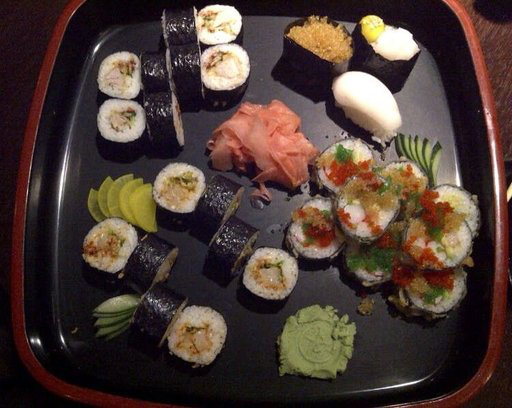

In [8]:
import random
from PIL import Image

#Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

#5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

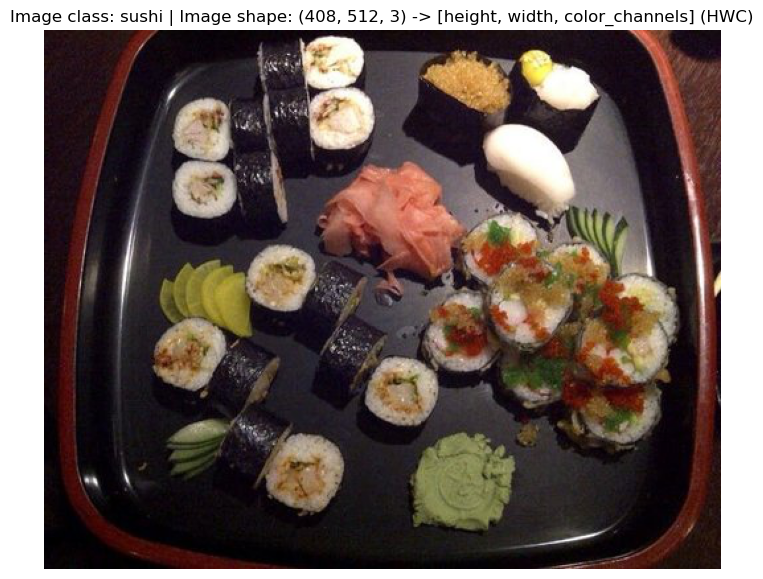

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.array(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors(in our case, numerical representation of our images).
2. Turn it into a 'torch.utils.data.Dataset' and subsequently a 'torch.untils.data.DataLoader', we'll call these 'Dataset' and 'DataLoader'.

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transdforming data with 'torchvision.transforms'

Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [11]:
#Write a transform for image
data_transform = transforms.Compose([
    #Resize our image to 64x64
    transforms.Resize(size=(64,64)),
    #Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img)

tensor([[[0.1294, 0.1373, 0.1412,  ..., 0.0863, 0.0824, 0.0824],
         [0.1294, 0.1373, 0.1412,  ..., 0.0902, 0.0902, 0.0863],
         [0.1294, 0.1412, 0.1333,  ..., 0.1059, 0.0980, 0.1137],
         ...,
         [0.0118, 0.0196, 0.0157,  ..., 0.1294, 0.1373, 0.1373],
         [0.0275, 0.0275, 0.0275,  ..., 0.1255, 0.1373, 0.1333],
         [0.0314, 0.0314, 0.0275,  ..., 0.1137, 0.1294, 0.1255]],

        [[0.0588, 0.0588, 0.0667,  ..., 0.0392, 0.0392, 0.0431],
         [0.0549, 0.0510, 0.0667,  ..., 0.0392, 0.0431, 0.0314],
         [0.0510, 0.0627, 0.0627,  ..., 0.0471, 0.0471, 0.0392],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0667, 0.0667, 0.0667],
         [0.0118, 0.0118, 0.0118,  ..., 0.0706, 0.0706, 0.0667],
         [0.0118, 0.0157, 0.0196,  ..., 0.0667, 0.0667, 0.0667]],

        [[0.0667, 0.0706, 0.0667,  ..., 0.0706, 0.0706, 0.0745],
         [0.0784, 0.0824, 0.0863,  ..., 0.0941, 0.0941, 0.0902],
         [0.0824, 0.0863, 0.0941,  ..., 0.0941, 0.1059, 0.

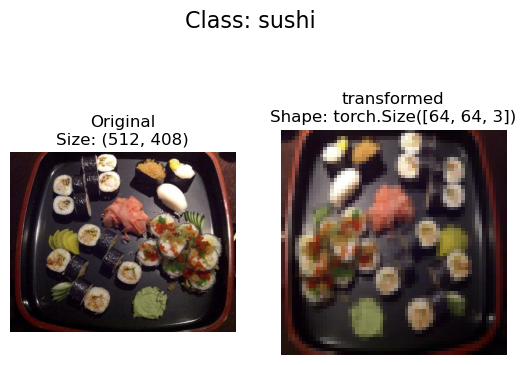

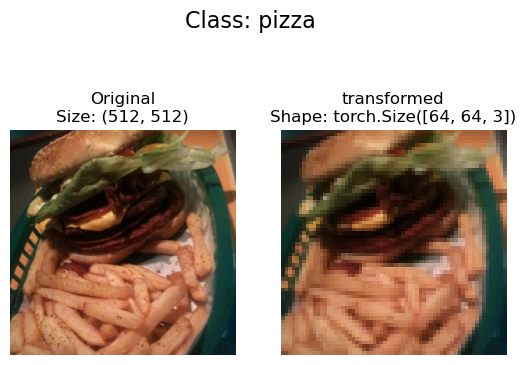

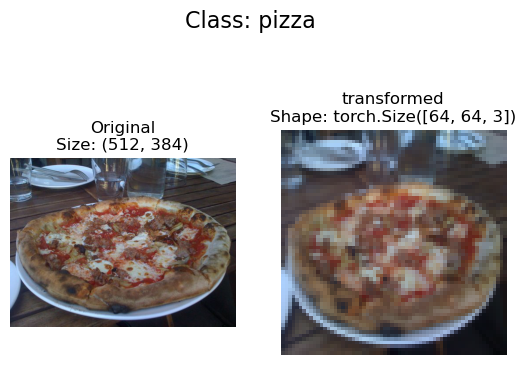

In [13]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms
    them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_paths =  random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            #Transform and plot target image
            transformed_image = transform(f).permute(1,2,0) # note we will need to change shape for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list, transform=data_transform, seed=42)    

## 4. Option 1: Loading image data using 'ImageFolder'

We can load image classification using 'torchvision.datasets.ImageFolder' - https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder 

In [14]:
#Use image folder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform = data_transform, # a transfrom for the data
                                  target_transform=None) # atransform for the label
test_data = datasets.ImageFolder(root = test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get classnmes as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [19]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

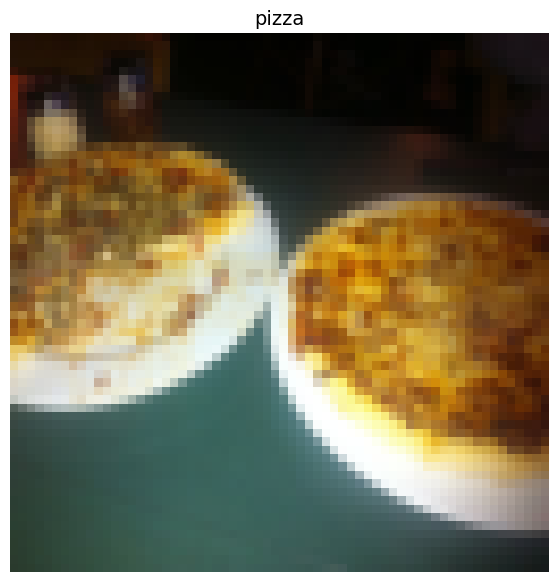

In [20]:
# Rearrange the order of dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

#Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=14)

## 4.1 Turn loaded images into 'DataLoaders"

A 'DataLoader' is going to help us turn our 'Dataset' into iterables and we can customize the 'batch_size' so our model can see 'batch_size' images at a time.

In [21]:
import os
os.cpu_count()

12

In [22]:
# Turn train and test datasets into dataloaders
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers= 1, shuffle= True)
test_dataloader = DataLoader(dataset=test_data, batch_size= BATCH_SIZE, num_workers= 1, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x209cd127100>,
 <torch.utils.data.dataloader.DataLoader at 0x209cd1275b0>)

In [23]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [24]:
img, label = next(iter(train_dataloader))

# Change batchsize if needed
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")


Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 5. Option 2: Loading image data with a Custom 'Dataset'

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the dataset

Pros: 
* Can create a 'Dataset' out of almost anything
* Not limited to PyTorch pre-build 'Dataset' functions

Cons:
* Even though you could create 'Dataset' out of almost anything, it dosent mean it will work...
* Using a custom 'Dataset' often results in us writing more code, which could be prone to errors or performance issue.

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [25]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [26]:
# Instance from torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Create helper functions to get class names

We want a function to:
1. Get class names using 'os.scan_dir()' to traverse a target directory (ideally the directory is in standard image classification format).
2. Raiese an error if the clas names arent fond (if this happens, there might be something wrong with the directory structure)
3. Turn the class names into a dict and list and return them.

In [27]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [28]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str,int]]:
    """
    Finds the class folder names inaside a target directory. 
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldnt find any classes in {directory}... please check file structure") 
    
    # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    
    return classes, class_to_idx

In [29]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom 'Dataset' to replicate 'ImageFolder'

To create our own custom dataset, we want to:

1. Subclass 'torch.utils.data.Dataset'
2. Init our subclass with a target directory (the directory we'd like to get our data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of target classes
    * class_ti_idx - a dict of target classes mapped to integer labels
4. Create a function to 'load_images()', this function will open an image
5. Overwrite the '__len()__' method to return the length of our dataset
6. Overwrite the '__getitem()__' method to return a given sample when passed an index

In [30]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass  torch.utils.data.Dataset 
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, 
                 targ_dir: str,
                 transform= None):
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)
        
    # 4. Create a function to load images
    def load_images(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len__()
    def __len__(self) -> int:
        " Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X,y)."
        img = self.load_images(index)
        class_name = self.paths[index].parent.name # Expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]
        
        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx #return data, label (X,y)
        else:
            return img, class_idx # Returns untransformed image and label

In [31]:
# Create a transform 
from torchvision import transforms
train_transforms = transforms.Compose([
                                        transforms.Resize(size=(64,64)),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.ToTensor()
])

test_transforms = transforms.Compose([
                                        transforms.Resize(size=(64,64)),
                                        transforms.ToTensor()
])

In [32]:
# Test out image folder custom class
train_data_custom = ImageFolderCustom(targ_dir= train_dir, transform= train_transforms)
test_data_custom = ImageFolderCustom(targ_dir= test_dir, transform= test_transforms)

In [33]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x209cd126740>,
 <__main__.ImageFolderCustom at 0x209cd126200>)

In [34]:
len(train_data), len(train_data_custom)

(225, 225)

In [35]:
len(test_data), len(test_data_custom)

(75, 75)

In [36]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [37]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [38]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a 'Dataset' abd a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducability
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot
6. Loop through the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [39]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n is too high
    if n>10:
        n=10
        display_shape = False
        print(f"For display, purposes, n shouldnt be larger than 10,  setting to 10 and removing shape display.")

    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)),k=n)

    # 5. Setup plot 
    plt.figure(figsize=(16,8))

    # 6. Loopthrough random indexes and plot them with matplotlib
    for i,targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1,2,0) # [C,H,W] -> [H,W,C]

        # Plot adjusted samples 
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)   
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

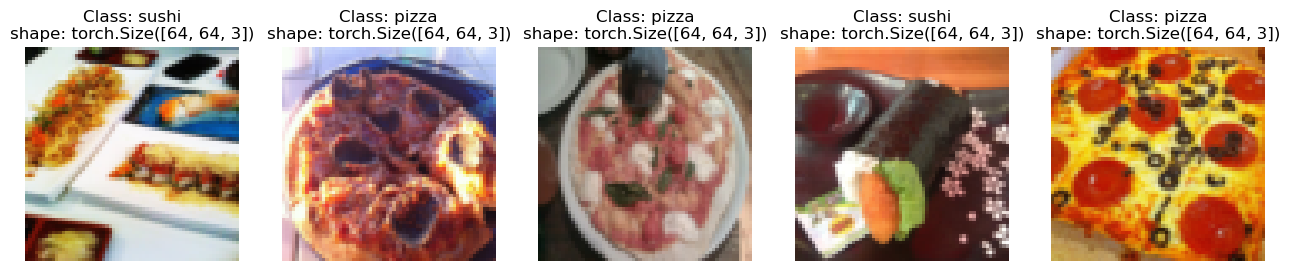

In [40]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data, n = 5, classes= class_names, seed = 42)

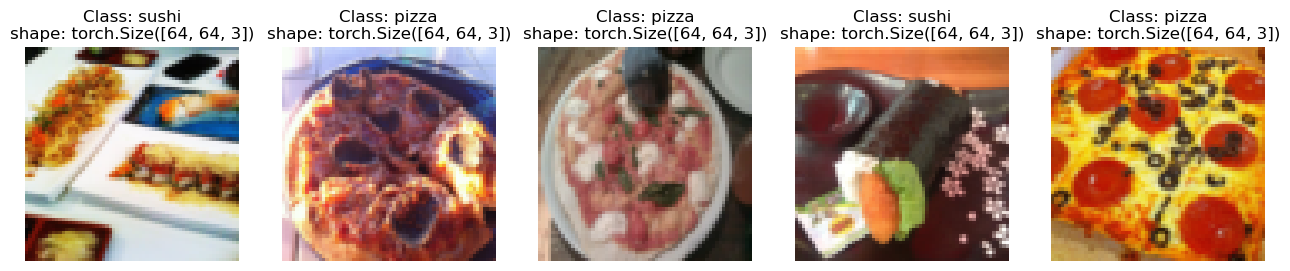

In [41]:
# Display random images from the ImageFolderCustom created Dataset
display_random_images(train_data_custom, n = 5, classes= class_names, seed = 42)

### 5.4 Turn custom loaded images into DataLoader's

In [42]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset= train_data_custom,
                                     batch_size= BATCH_SIZE,
                                     num_workers= 0,
                                     shuffle= True)

test_dataloader_custom = DataLoader(dataset= test_data_custom,
                                    batch_size= BATCH_SIZE,
                                    num_workers= 0,
                                    shuffle= False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x209cd92f3d0>,
 <torch.utils.data.dataloader.DataLoader at 0x209cd5d5c60>)

In [43]:
len(train_dataloader_custom), len(test_dataloader_custom)

(8, 3)

In [44]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artifically adding diversity to your training data. 

In the case of image data, this may mean applying various image transformations to the training images.  

This practice hopefully results in a model thats more generalizable to unseen data.

Let's take a look at one perticular type of data augmentation used to train PyTorch vision models to state of the art levels...

Blog Post - https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [45]:
# Lets look at trivialaugment - 
from torchvision import transforms
train_transform = transforms.Compose([
                                        transforms.Resize(size=(224,224)),
                                        transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                        transforms.ToTensor()
])
test_transform = transforms.Compose([
                                        transforms.Resize(size=(224,224)),
                                        transforms.ToTensor()
])
train_transform, test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
 ))

In [46]:
# GEt all the image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

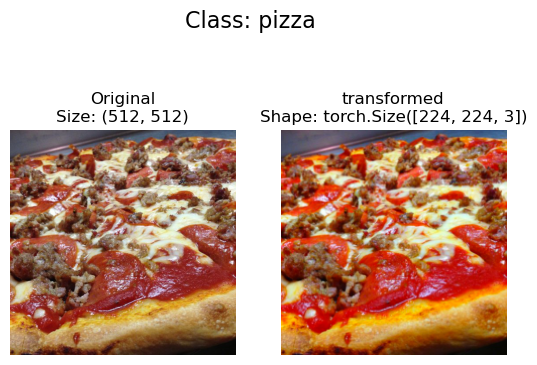

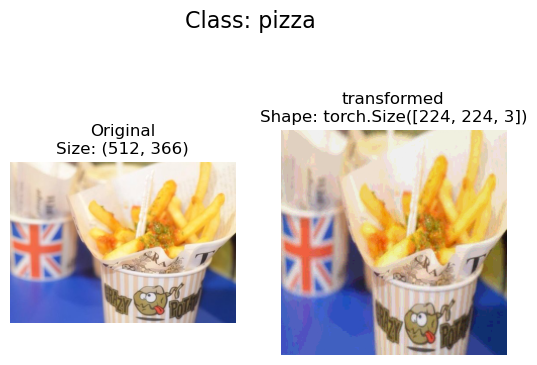

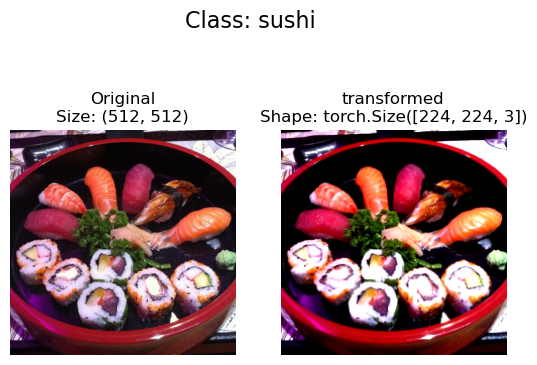

In [47]:
# Plot random images
plot_transformed_images(image_paths=image_path_list,
                        transform = train_transform,
                        n=3,
                        seed=None)

## 7. Model 0: Tiny VGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

### 7.1 Create transforms and loading data for Model 0

In [48]:
# Create a simple transform
simple_transform = transforms.Compose([ 
                                       transforms.Resize(size=(64,64)),
                                       transforms.ToTensor()
                                       ])

In [49]:
# 1. Load the transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform = simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform= simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

#Setup batchsize and num_workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(dataset= train_data_simple,
                                     batch_size= BATCH_SIZE,
                                     shuffle= True,
                                     num_workers= NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset= test_data_simple,
                                    batch_size= BATCH_SIZE,
                                    shuffle= False,
                                    num_workers= NUM_WORKERS)
len(train_dataloader_simple), len(test_dataloader_simple)

(8, 3)

### 7.2 Create TinyVGG model class

In [50]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self,input_shape:int,
                 hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels= input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride= 1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d( in_channels= hidden_units, out_channels= hidden_units, kernel_size= 3, stride= 1, padding= 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels= hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride= 1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d( in_channels= hidden_units, out_channels= hidden_units, kernel_size= 3, stride= 1, padding= 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential( 
                                        nn.Flatten(),
                                        nn.Linear(in_features= hidden_units *13*13,
                                                   out_features= output_shape))
    
    def forward(self,x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x= self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) #benifits from operator fusion : https://horace.io/brrr_intro.html
        

In [51]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape= 3, hidden_units= 10, output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [52]:
# GEt a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [53]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6317e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0047e-03],
        [ 2.0999e-02,  1.2869e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7293e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1838e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4455e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7724e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5021e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8261e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

### 7.4 Use 'torchinfo' to get an idea of the shapes going through our model

In [54]:
try:
    import torchinfo
except: 
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create train and test loop functions

* 'train_step()' - takes in a model and dataloader and trains the model on the dataloader.
* 'test_step()' - takes in a model and sataloader and evluates the model on the dataloader.

In [55]:
# Create train_step()

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put the model in train mode 
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0,0

    # Loop through data loader and data batches
    for batch, (X,y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Caclulate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calcualte the accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjust metrics to get the average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [56]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through Dataloader batches
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)

            #1. Forward pass
            test_pred_logits = model(X)

            #2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    
    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Create a 'train()' function to combine 'train_step()' and 'test_step()'

In [57]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dtaloaders + loss function
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn : torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int =5):
    
    # 2. Create an empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model, 
                                           dataloader=train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer)
        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn)
        
        #4. Print out whats happening
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss: .4f} | Test acc: {test_acc:.4f}")

        # 5. Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc) 
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc) 

    # 6. Return the filled results at the end of the epochs
    return results

c:\Users\USER\anaconda3\envs\pytorch-gpu-python-3-10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 7.7 Train and evaluate model 0

In [58]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs 
NUM_EPOCHS = 5

# Recreate an instance of tinyVGG
model_0 = TinyVGG(input_shape= 3, # Number of color channels of out input images
                  hidden_units= 10,
                  output_shape= len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model_0.parameters(), lr = 0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model 0
model_0_results = train(model_0,
                        train_dataloader= train_dataloader_simple,
                        test_dataloader= test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs= NUM_EPOCHS)

#End the timer and print out how long it took
end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")


 20%|██        | 1/5 [00:09<00:39,  9.89s/it]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss:  1.0983 | Test acc: 0.3116


 40%|████      | 2/5 [00:19<00:29,  9.88s/it]

Epoch: 1 | Train loss: 1.0995 | Train acc: 0.3320 | Test loss:  1.0699 | Test acc: 0.5417


 60%|██████    | 3/5 [00:29<00:20, 10.03s/it]

Epoch: 2 | Train loss: 1.0863 | Train acc: 0.4922 | Test loss:  1.0800 | Test acc: 0.5227


 80%|████████  | 4/5 [00:39<00:09,  9.99s/it]

Epoch: 3 | Train loss: 1.0826 | Train acc: 0.4102 | Test loss:  1.0599 | Test acc: 0.5729


100%|██████████| 5/5 [00:49<00:00,  9.97s/it]

Epoch: 4 | Train loss: 1.0631 | Train acc: 0.4141 | Test loss:  1.0611 | Test acc: 0.5540
Total training time: 49.852 seconds


In [59]:
model_0_results

{'train_loss': [1.1063424199819565,
  1.0994838029146194,
  1.0862900465726852,
  1.082635834813118,
  1.063070684671402],
 'train_acc': [0.3046875, 0.33203125, 0.4921875, 0.41015625, 0.4140625],
 'test_loss': [1.0983142852783203,
  1.069852630297343,
  1.080026110013326,
  1.059850811958313,
  1.06112007300059],
 'test_acc': [0.31155303030303033,
  0.5416666666666666,
  0.5227272727272728,
  0.5729166666666666,
  0.5539772727272728]}

### 7.8 Plot the loss curves of model 0

A **loss curve** is a ay of tracking your models's progress over time

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [60]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [61]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary."""
    # Get the loss values of the results dictionary (training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15,7))

    #Plot the loss 
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label= "test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label = "test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

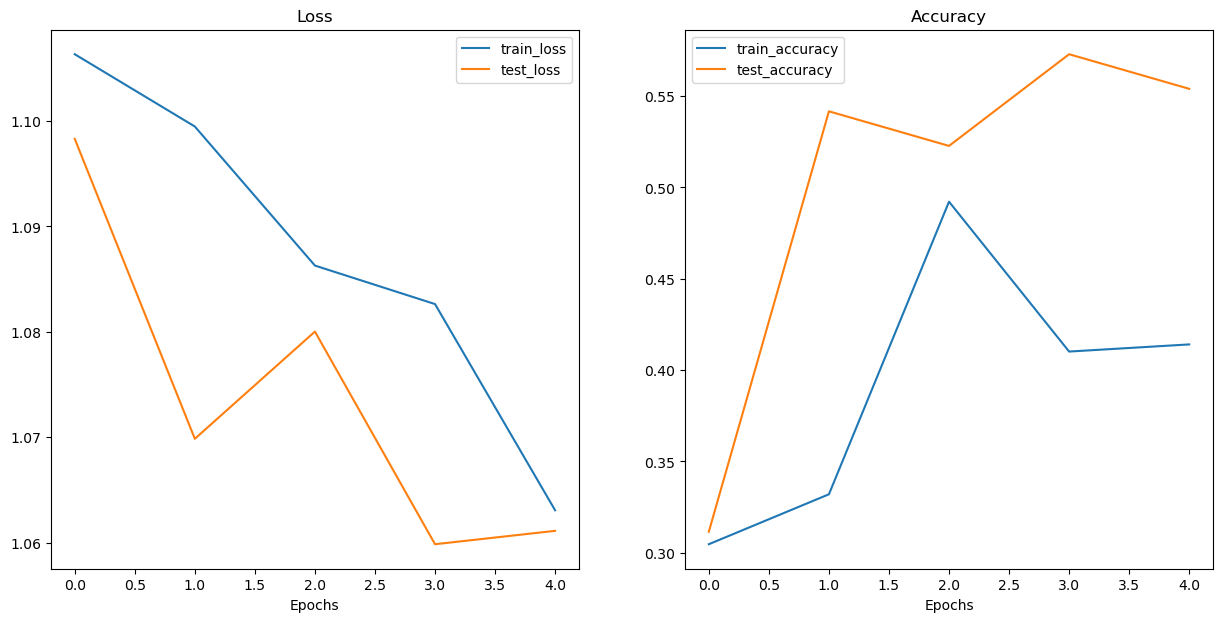

In [62]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model.

Looking at training and test loss curves is a great way to see if your model is **overfitting**.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is **overfitting**.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered **underfitting**.

The ideal position for a training and test loss curve is for them to line up closely with each other.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>

*Left: If your training and test loss curves aren't as low as you'd like, this is considered **underfitting**. *Middle:* When your test/validation loss is higher than your training loss this is considered **overfitting**. *Right:* The ideal scenario is when your training and test loss curves line up over time. This means your model is generalizing well. There are more combinations and different things loss curves can do, for more on these, see Google's [Interpreting Loss Curves guide](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic).*

### 8.1 How to deal with overfitting

Since the main problem with overfitting is that you're model is fitting the training data *too well*, you'll want to use techniques to "reign it in".

A common technique of preventing overfitting is known as [**regularization**](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html).

I like to think of this as "making our models more regular", as in, capable of fitting *more* kinds of data.

Let's discuss a few methods to prevent overfitting.

| **Method to prevent overfitting** | **What is it?** |
| ----- | ----- |
| **Get more data** | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples. | 
| **Simplify your model** | If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer. | 
| **Use data augmentation** | [**Data augmentation**](https://developers.google.com/machine-learning/glossary#data-augmentation) manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data. |
| **Use transfer learning** | [**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images. |
| **Use dropout layers** | Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more. | 
| **Use learning rate decay** | The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to [**convergence**](https://developers.google.com/machine-learning/glossary#convergence), the smaller you'll want your weight updates to be.  |
| **Use early stopping** | [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) stops model training *before* it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior). |

There are more methods for dealing with overfitting but these are some of the main ones.

As you start to build more and more deep models, you'll find because deep learnings are *so good* at learning patterns in data, dealing with overfitting is one of the primary problems of deep learning.

### 8.2 How to deal with underfitting 

When a model is [**underfitting**](https://developers.google.com/machine-learning/glossary#underfitting) it is considered to have poor predictive power on the training and test sets.

In essence, an underfitting model will fail to reduce the loss values to a desired level.

Right now, looking at our current loss curves, I'd considered our `TinyVGG` model, `model_0`, to be underfitting the data.

The main idea behind dealing with underfitting is to *increase* your model's predictive power.

There are several ways to do this.

| **Method to prevent underfitting** | **What is it?** |
| ----- | ----- |
| **Add more layers/units to your model** | If your model is underfitting, it may not have enough capability to *learn* the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers. | 
| **Tweak the learning rate** | Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens. |
| **Use transfer learning** | Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem. |
| **Train for longer** | Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance. |
| **Use less regularization** | Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better. |

### 8.3 The balance between overfitting and underfitting

None of the methods discussed above are silver bullets, meaning, they don't always work.

And preventing overfitting and underfitting is possibly the most active area of machine learning research.

Since everone wants their models to fit better (less underfitting) but not so good they don't generalize well and perform in the real world (less overfitting).

There's a fine line between overfitting and underfitting.

Because too much of each can cause the other.

Transfer learning is perhaps one of the most powerful techniques when it comes to dealing with both overfitting and underfitting on your own problems.

Rather than handcraft different overfitting and underfitting techniques, transfer learning enables you to take an already working model in a similar problem space to yours (say one from [paperswithcode.com/sota](https://paperswithcode.com/sota) or [Hugging Face models](https://huggingface.co/models)) and apply it to your own dataset.

We'll see the power of transfer learning in a later notebook.

## 9. Model 1: TinyVGG with Data Augmentation

Now lets try another modelling experiment this time using the same model as before with some data augmentation

### 9.1 Create transform with data augmentation

In [63]:
# Create data transforms with trivial augment
from torchvision import transforms
train_transform_trivial = transforms.Compose([ 
                                              transforms.Resize(size=(64,64)),
                                              transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                              transforms.ToTensor()
                                              ])

test_transform_simple = transforms.Compose([ 
                                            transforms.Resize(size=(64,64)),
                                            transforms.ToTensor()
                                            ])
train_transform_trivial, test_transform_simple

(Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
 ))

### 9.2 Create train and test Dataset's and Dataloader's with data augmentation

In [64]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root = train_dir,
                                            transform = train_transform_trivial)
test_data_simple = datasets.ImageFolder(root= test_dir,
                                        transform= test_transform_simple)

In [65]:
# Turn our datasets into dataloaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()


torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset = train_data_augmented,
                                        batch_size= BATCH_SIZE,
                                        shuffle= True,
                                        num_workers= NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset= test_data_simple,
                                    batch_size= BATCH_SIZE,
                                    shuffle= False,
                                    num_workers= NUM_WORKERS)

### 9.3 Construct and train model 1

This tume we'll be using the same model architecture except this time we've augmented the training data

In [66]:
# Create model _ and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape= 3,
                  hidden_units= 10,
                  output_shape= len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Wonderful! Now we've a model and dataloader's, lets create a function and an optimizer and call upon our 'train()' function and evaluate our model.

In [67]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model_1.parameters(), lr= 0.001)

# Start the timer
from timeit import default_timer as Timer
start_timer = timer()

# Train_model 1
model_1_results = train(model= model_1,
                        train_dataloader= train_dataloader_augmented,
                        test_dataloader= test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs= NUM_EPOCHS)

# End timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_timer:.3f} seconds")

 20%|██        | 1/5 [00:10<00:42, 10.61s/it]

Epoch: 0 | Train loss: 1.1046 | Train acc: 0.2500 | Test loss:  1.1016 | Test acc: 0.2604


 40%|████      | 2/5 [00:20<00:30, 10.25s/it]

Epoch: 1 | Train loss: 1.0764 | Train acc: 0.4258 | Test loss:  1.1301 | Test acc: 0.2604


 60%|██████    | 3/5 [00:30<00:20, 10.10s/it]

Epoch: 2 | Train loss: 1.0733 | Train acc: 0.4258 | Test loss:  1.1678 | Test acc: 0.2604


 80%|████████  | 4/5 [00:41<00:10, 10.28s/it]

Epoch: 3 | Train loss: 1.1218 | Train acc: 0.3047 | Test loss:  1.1551 | Test acc: 0.2604


100%|██████████| 5/5 [00:51<00:00, 10.24s/it]

Epoch: 4 | Train loss: 1.0771 | Train acc: 0.4609 | Test loss:  1.1509 | Test acc: 0.2812
Total training time for model_1: 51.191 seconds


### 9.4 Plot the loss curves of model_1

A loss curve helps you evauluate your models performance overtime

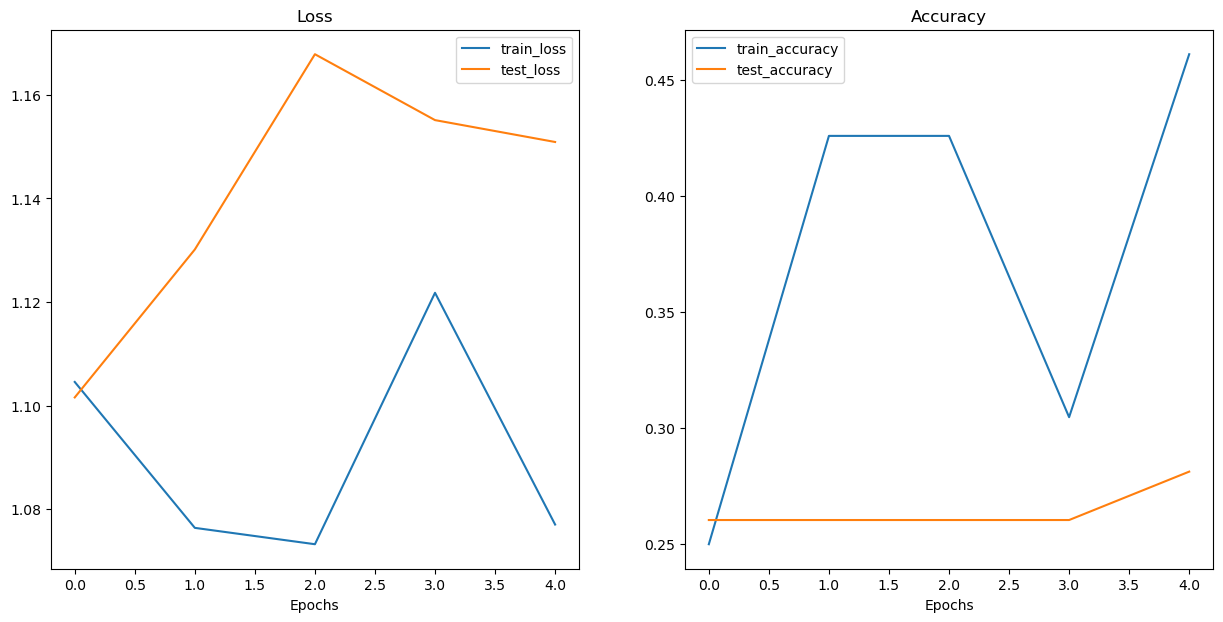

In [68]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, its important to compare them to each other.

There's a few different ways to do this:
1. Hard coding (what we're doing)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights and Biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org/

In [69]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106342,0.304688,1.098314,0.311553
1,1.099484,0.332031,1.069853,0.541667
2,1.086290,0.492188,1.080026,0.522727
3,1.082636,0.410156,1.059851,0.572917
4,1.063071,0.414062,1.061120,0.553977


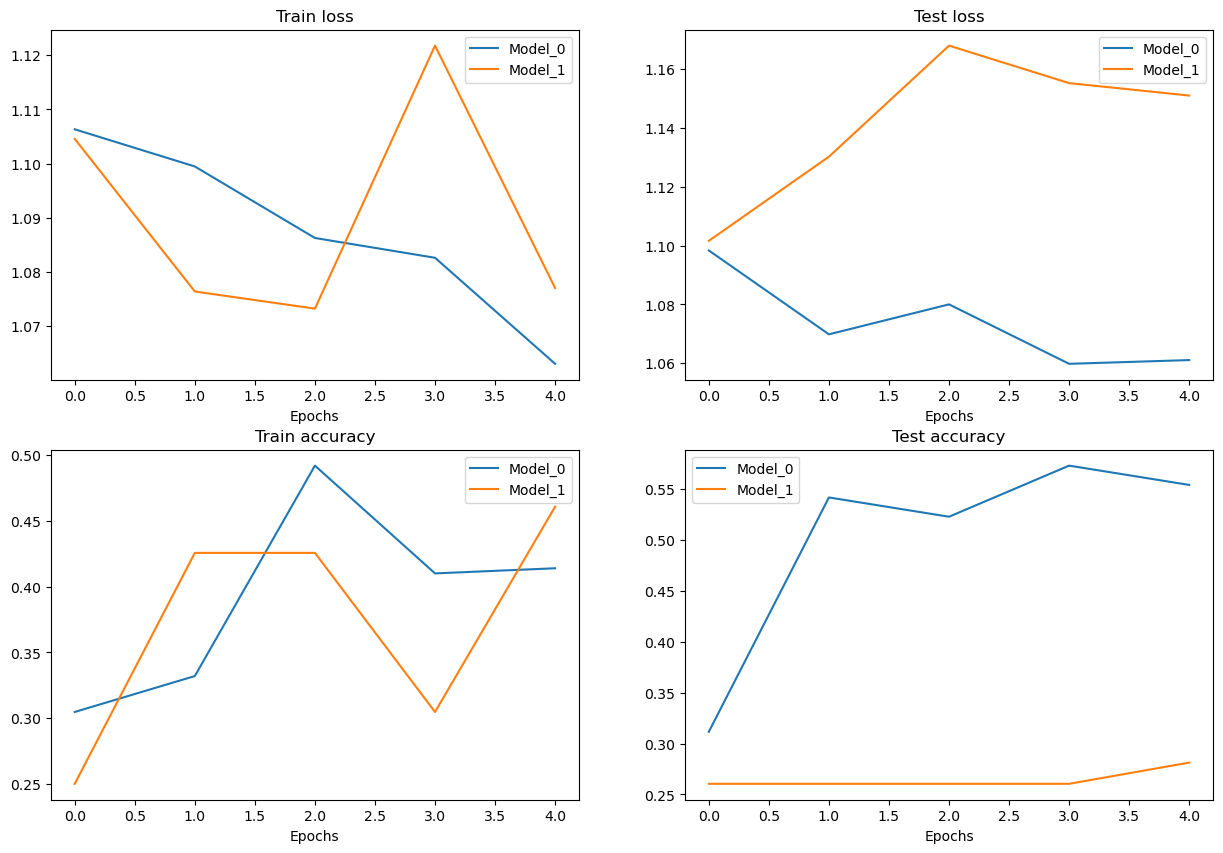

In [70]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number os epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model_0")
plt.plot(epochs, model_1_df["train_loss"], label="Model_1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model_0")
plt.plot(epochs, model_1_df["test_loss"], label="Model_1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model_0")
plt.plot(epochs, model_1_df["train_acc"], label="Model_1")
plt.title("Train accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model_0")
plt.plot(epochs, model_1_df["test_acc"], label="Model_1")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction on a custom image

Although we've trained a model an custom data.. how so you make a prediction on a sample/image thats not on training and testing dataset.

In [71]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpg"

# Download the image if it dosent already exist
if not custom_image_path.is_file():
    with open(custom_image_path,"wb") as f:
        # When dowloading from github use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path} ...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download..")

data\04-pizza-dad.jpg already exists, skipping download..


### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained open

* In tensor form with datatype (torch.float32)
* Of shape 64*64*3
* On the right device

We can read an image into PyTorch using: https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html

In [72]:
import torchvision 

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[155, 179, 180,  ...,  20,  17,  13],
         [146, 165, 182,  ...,  19,  17,  14],
         [124, 145, 173,  ...,  17,  16,  14],
         ...,
         [ 74,  61,  45,  ..., 150, 148, 146],
         [ 64,  57,  42,  ..., 150, 147, 144],
         [ 64,  62,  48,  ..., 149, 147, 144]],

        [[168, 192, 191,  ...,  23,  20,  16],
         [160, 179, 194,  ...,  22,  20,  17],
         [141, 159, 185,  ...,  20,  19,  17],
         ...,
         [ 55,  42,  26,  ..., 107, 105, 103],
         [ 45,  38,  23,  ..., 108, 105, 102],
         [ 45,  43,  29,  ..., 107, 105, 102]],

        [[122, 146, 148,  ...,  16,  13,   9],
         [111, 130, 148,  ...,  15,  13,  10],
         [ 89, 110, 139,  ...,  13,  12,  10],
         ...,
         [ 38,  25,   9,  ...,  52,  50,  48],
         [ 28,  21,   6,  ...,  50,  47,  44],
         [ 28,  26,  12,  ...,  47,  45,  42]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

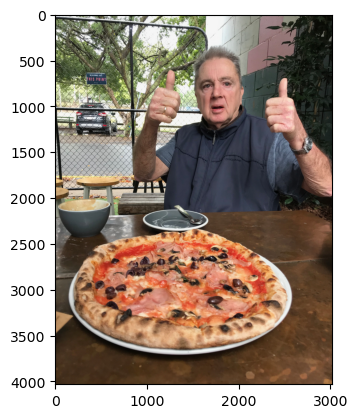

In [73]:
plt.imshow(custom_image_uint8.permute(1,2,0))

### 11.2 Making a prediction on a custom image with a trained PyTorch model


In [74]:
# Try to predict on an image in uint8 format
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [75]:
# Load in the custom image and convert to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.6078, 0.7020, 0.7059,  ..., 0.0784, 0.0667, 0.0510],
         [0.5725, 0.6471, 0.7137,  ..., 0.0745, 0.0667, 0.0549],
         [0.4863, 0.5686, 0.6784,  ..., 0.0667, 0.0627, 0.0549],
         ...,
         [0.2902, 0.2392, 0.1765,  ..., 0.5882, 0.5804, 0.5725],
         [0.2510, 0.2235, 0.1647,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2431, 0.1882,  ..., 0.5843, 0.5765, 0.5647]],

        [[0.6588, 0.7529, 0.7490,  ..., 0.0902, 0.0784, 0.0627],
         [0.6275, 0.7020, 0.7608,  ..., 0.0863, 0.0784, 0.0667],
         [0.5529, 0.6235, 0.7255,  ..., 0.0784, 0.0745, 0.0667],
         ...,
         [0.2157, 0.1647, 0.1020,  ..., 0.4196, 0.4118, 0.4039],
         [0.1765, 0.1490, 0.0902,  ..., 0.4235, 0.4118, 0.4000],
         [0.1765, 0.1686, 0.1137,  ..., 0.4196, 0.4118, 0.4000]],

        [[0.4784, 0.5725, 0.5804,  ..., 0.0627, 0.0510, 0.0353],
         [0.4353, 0.5098, 0.5804,  ..., 0.0588, 0.0510, 0.0392],
         [0.3490, 0.4314, 0.5451,  ..., 0.0510, 0.0471, 0.

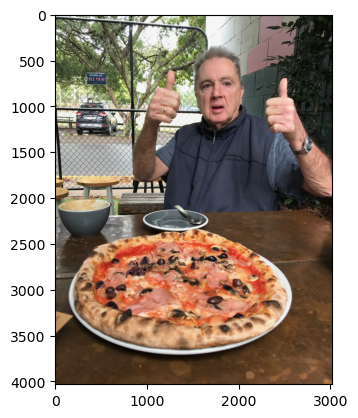

In [76]:
plt.imshow(custom_image.permute(1,2,0))

In [77]:
model_1.eval()
with torch.inference_mode():
    model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [78]:
# Create a transform pipeline to resize image
from torchvision import transforms
custom_image_transforms = transforms.Compose([transforms.Resize(size=(64,64))])


# Transform target image
custom_image_transformed = custom_image_transforms(custom_image)

# Print out the shapes
print(f"Original Shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original Shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


c:\Users\USER\anaconda3\envs\pytorch-gpu-python-3-10\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


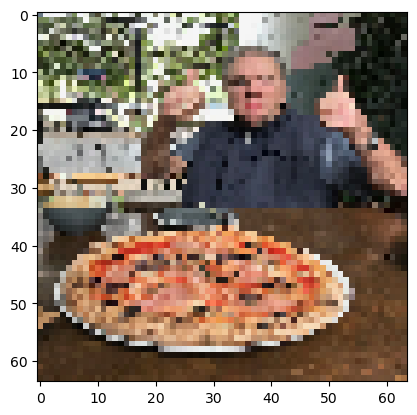

In [79]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [80]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [81]:
# Batch size
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [82]:
custom_image_transformed.shape

torch.Size([3, 64, 64])

In [83]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0476,  0.0626, -0.2105]], device='cuda:0')

In [84]:
class_names

['pizza', 'steak', 'sushi']

Note, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3,64,64) with a batch size (1,3,64,64)
* Make sure the image was on the same device as our model

In [85]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim = 1)
custom_image_pred_probs

tensor([[0.3587, 0.3642, 0.2771]], device='cuda:0')

In [86]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_labels

tensor([1])

In [87]:
class_names[custom_image_pred_labels]

'steak'

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:
    
A function where we pass an image path to and have our model predict on that image and plot the  image + prediction.

In [92]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device = device):
    """Make a prediction on a target image with a trained model and plots the image and prediction."""
    # Load in the image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # Divide the image pixel by 255 to get them between 0 and 1.
    target_image = target_image/255.
    
    # Transform if necessary
    if transform:
        target_image = transform(target_image)
        
    # Makre sure the model is on target device
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image (this is the batch dimension, eg. our model will predict on 1x images)
        target_image = target_image.unsqueeze(0)
        
        # Make a prediction on the image with an extra dimension
        target_image_pred = model(target_image.to(device)) # Make sure the target is on the right device
        
    # Convert logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    
    # Ligits -> pred labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dimension and rearrange shape
    if class_names: 
        title= f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    
    else:
        title: f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

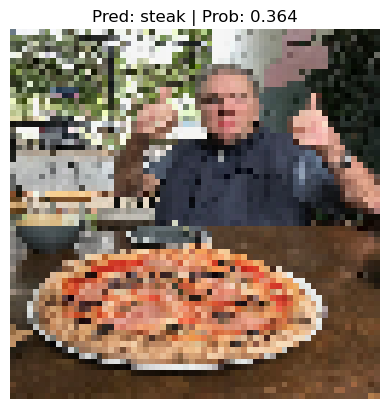

In [96]:
# Pred on our custom image
pred_and_plot_image(model= model_1,
                    image_path = custom_image_path,
                    class_names = class_names,
                    transform = custom_image_transforms,
                    device= device
                    )